## Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
from itertools import product
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("WAG_C_M.csv", sep=";", index_col=['month'], parse_dates=['month'], dayfirst=True)
data.tail()

,WAG_C_M
month,
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0
2016-07-01,35888.0
2016-08-01,34095.0


## 1. Визуальный анализ ряда

<AxesSubplot:xlabel='month'>

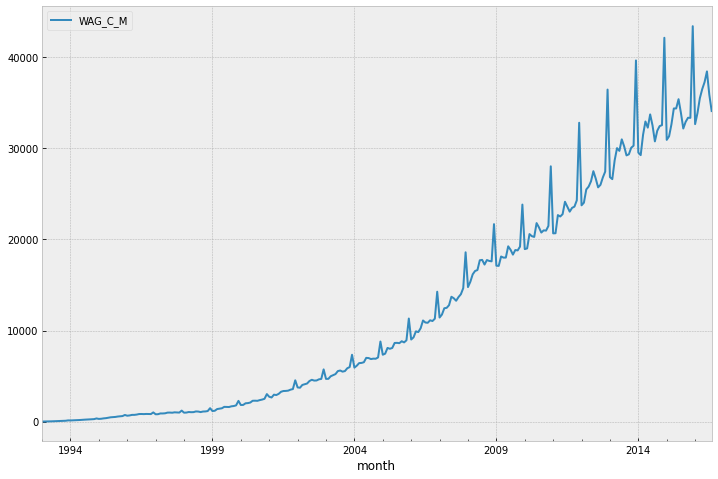

In [3]:
data.plot(figsize=(12,8))

Сразу видно, что ряд не является стационарным, во-первых, в ряде ярко выраженный тренд, во-вторых, присутствует сезонность, в-третьих, увеличивается дисперсия разброса данных. Воспользуемся критерием Дики-Фуллера, чтобы подтвердить нестационарность:

In [4]:
result = adfuller(data.WAG_C_M)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.813411
p-value: 0.991850
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573


Таким образом, тест Дики-Фуллера ещё раз подтвердил, что ряд является нестационарным p-value 0.99.

## 2. Стабилизация дисперсии

По изображению исходного ряда видно, что разброс дисперсии увеличивается со временем. Применим преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


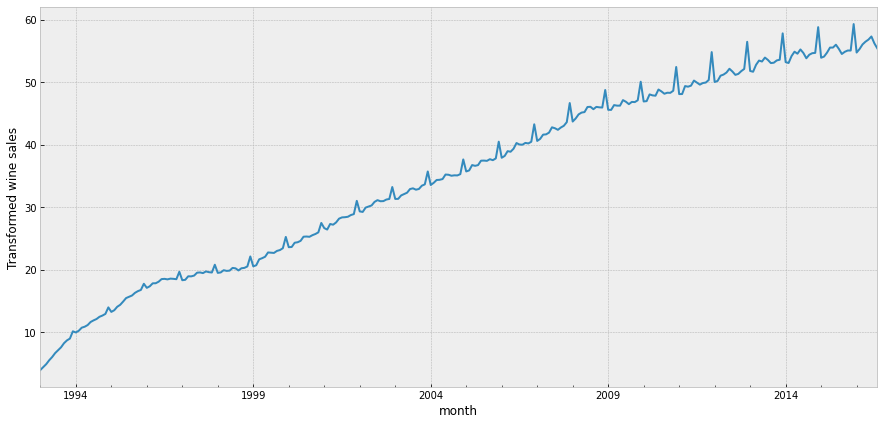

In [5]:
data['wages'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wages.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wages)[1])

<Figure size 1440x720 with 0 Axes>

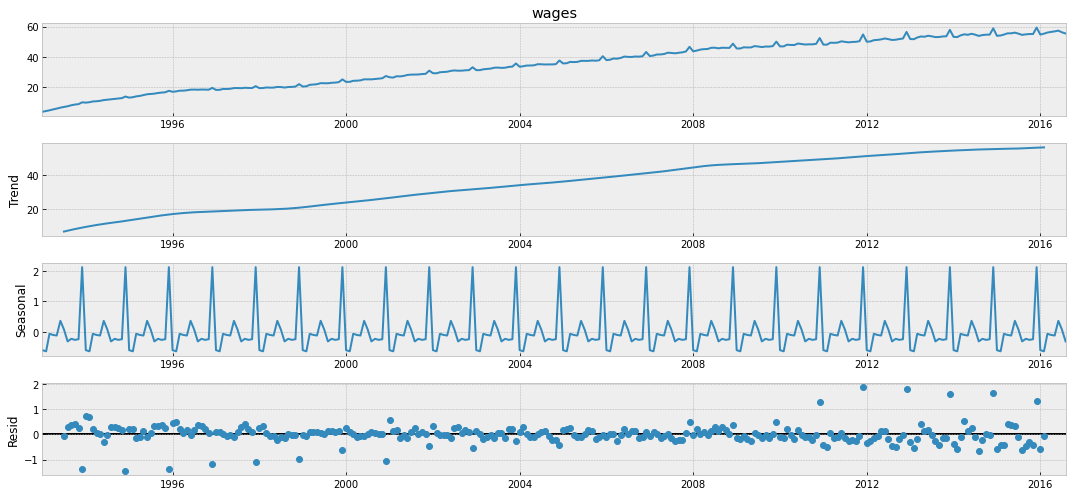

In [6]:
plt.figure(figsize=(20,10))
sm.tsa.seasonal_decompose(data.wages).plot();

Таким образом видно, что разброс дисперсии уменьшился, p-value 0.69, гипотеза о нестационарности все ещё принимается.

## 3. Выбор порядка дифференцирования

<Figure size 1440x720 with 0 Axes>

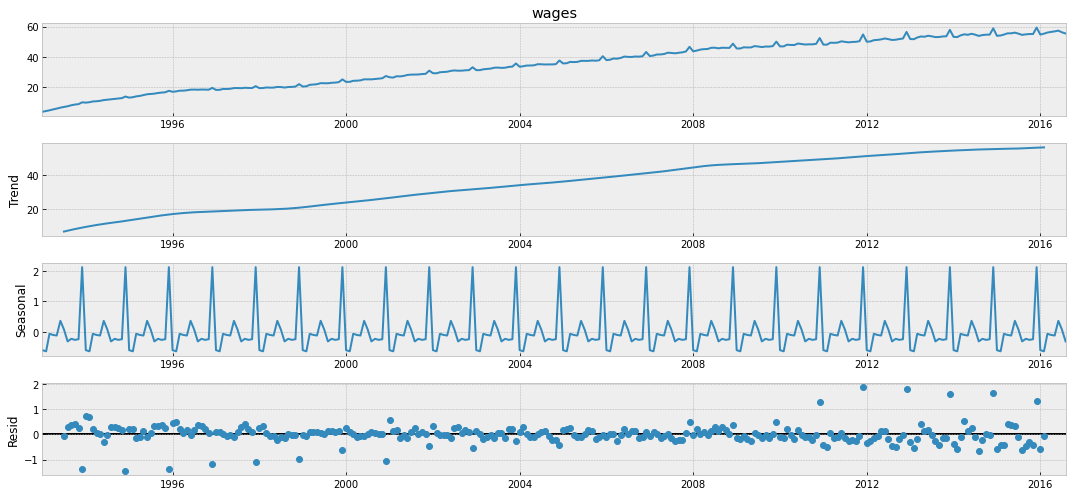

In [7]:
plt.figure(figsize=(20,10))
sm.tsa.seasonal_decompose(data.wages).plot();

Из разложения ряда на компоненты видно, что в данных присутствует восходящий тренд, для того, чтобы избавиться от тренда воспользуемся дифференцированием. Начнем с сезонного дифференцирования S=12, что видно из сезонности:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

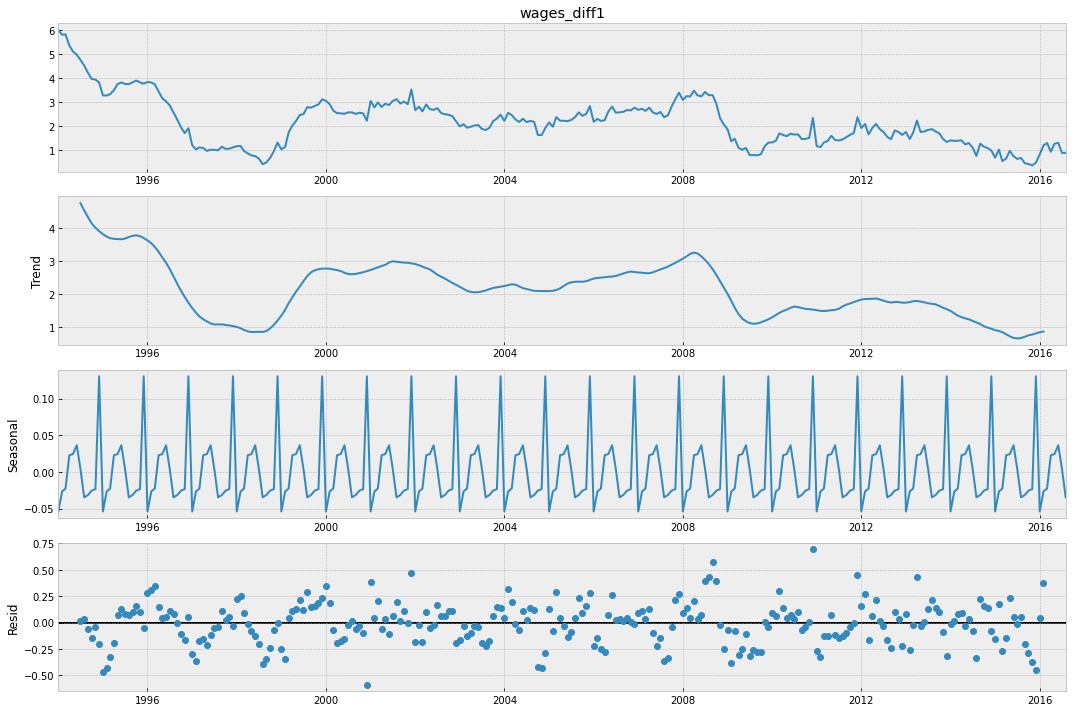

In [8]:
data['wages_diff1'] = data.wages - data.wages.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wages_diff1[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wages_diff1[12:])[1])

Характер тренда изменился, попробуем применить ещё одно дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

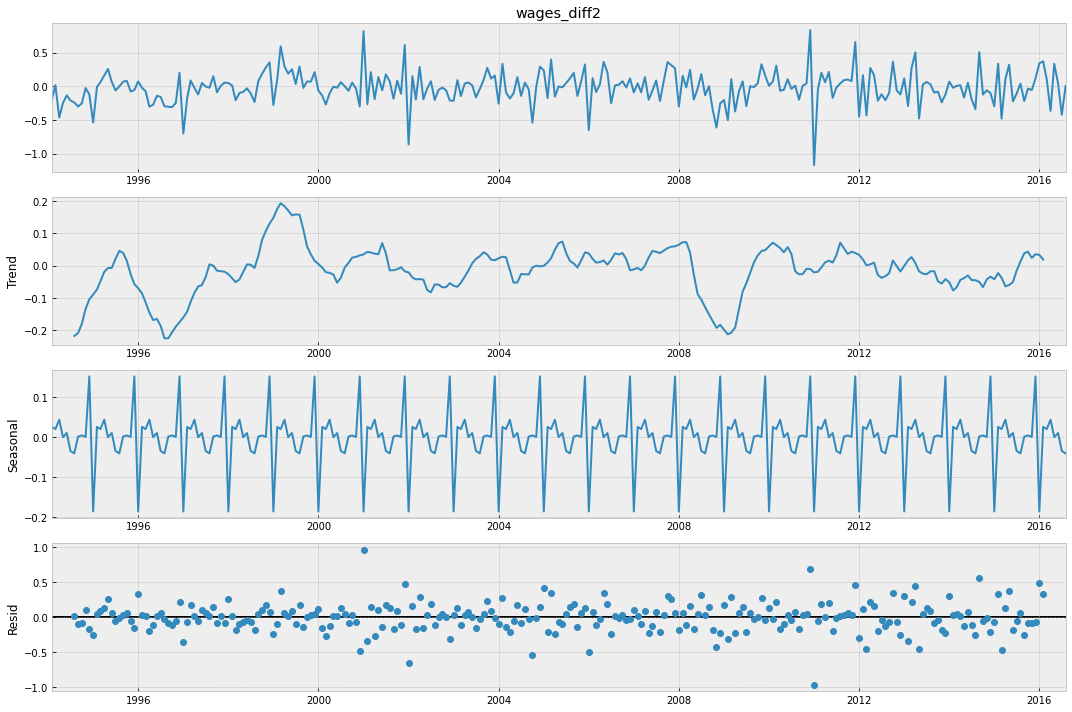

In [9]:
data['wages_diff2'] = data.wages_diff1 - data.wages_diff1.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wages_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wages_diff2[13:])[1])

Таким образом, с помощью двух последовательных дифференцирований: сезонного и обычного, мы избавились от тренда. Исходный ряд стал стационарным p-value стремится к 0.

## 4. Выбор начальных приближений для p, q, P, Q

Для выбора начальных приближений q, Q и p, P воспользуемся графиками автокорреляции и частичной автокорреляции:

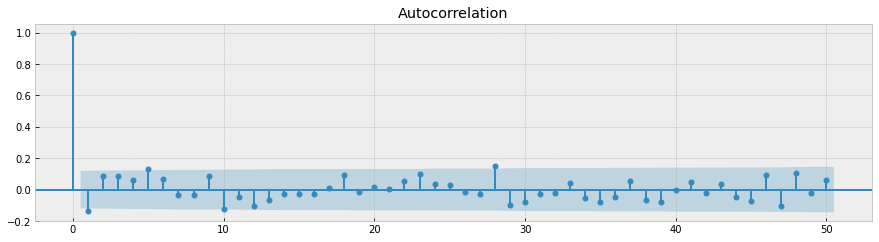

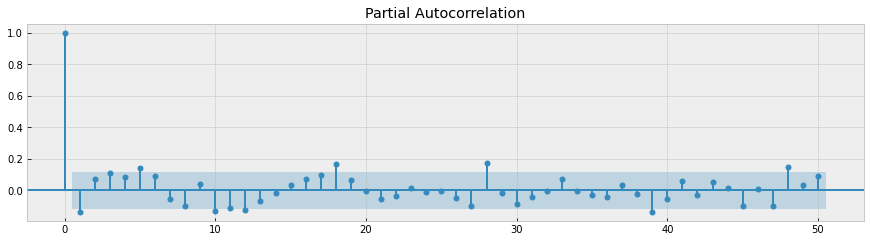

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wages_diff2[12:].dropna().values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wages_diff2[12:].dropna().values.squeeze(), lags=50, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=1, p=1|

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [11]:
Q=0
q=1
P=1
p=1

In [12]:
ps = range(0, p+1)
d=1
qs = range(0, q+1)
Ps = range(0, P+1)
D=1
Qs = range(0, Q+1)

In [13]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [14]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wages.dropna(), order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1.55 s, sys: 149 ms, total: 1.69 s
Wall time: 913 ms


In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head()) # информационный критерий Акаике

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


In [16]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              wages   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Wed, 10 Mar 2021   AIC                              0.341
Time:                                    11:58:18   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

## 6. Анализ остатков построенной модели

Зачем? Если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения.

Критерий Стьюдента: p=0.090791
Критерий Дики-Фуллера: p=0.000003


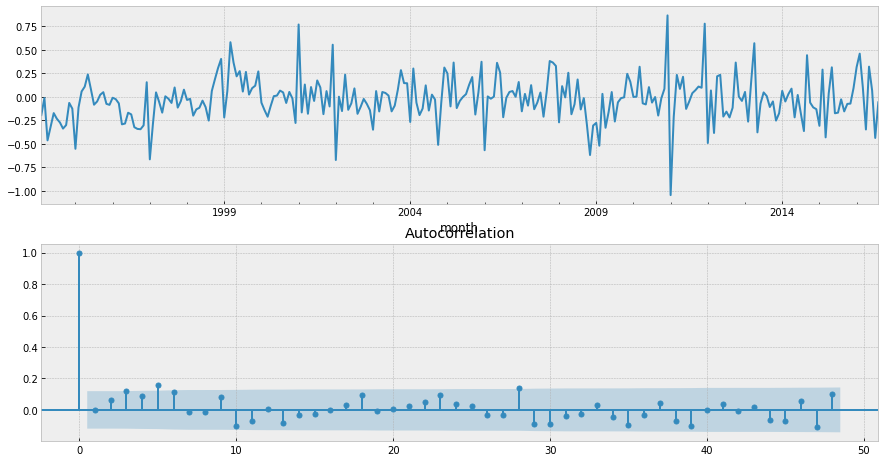

In [17]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента на 5% уровне значимости) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

## 7. Прогнозирование с помощью финальной модели

Проверим, насколько хорошо обучилась наша модель:

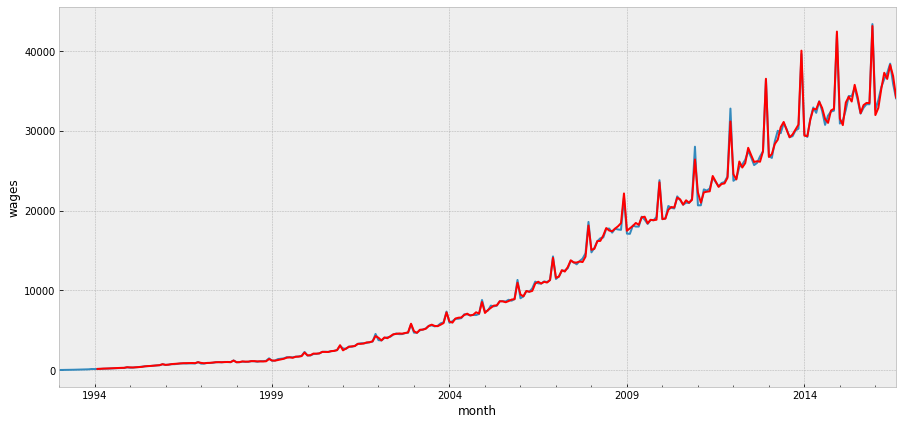

In [18]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('wages')
pylab.show()

Построение прогноза:

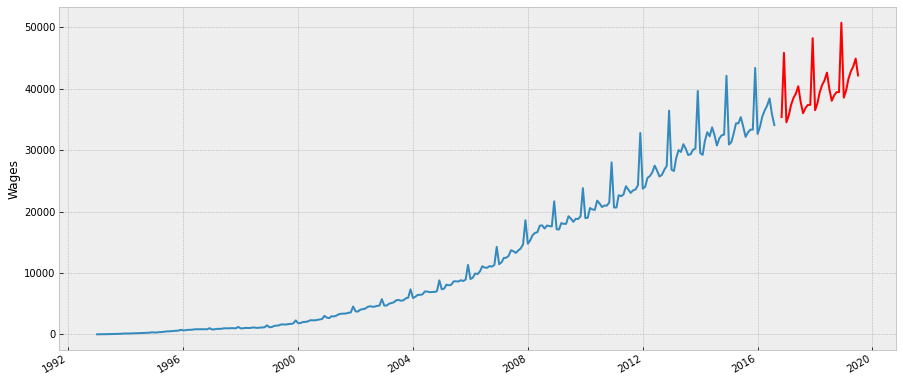

In [20]:
wages2 = data[['WAG_C_M']]
date_list = [datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wages2.columns)
wages2 = pd.concat([wages2, future])
wages2['forecast'] = invboxcox(best_model.predict(start=286, end=360), lmbda)

plt.figure(figsize(15,7))
wages2.WAG_C_M.plot()
wages2.forecast.plot(color='r')
plt.ylabel('Wages')
pylab.show()